In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sb
import glob

In [2]:
# loading the data

df = pd.read_csv('DNS_datastore.csv', index_col=0)
features = list(df.columns)[11:]

x = np.array(df.loc[:,features].fillna(0))
y = np.array(df['Label'])

sigma = (0.03 * x.mean(axis=0))

#### hyperparameter tuning of the RF model

In [20]:
%%time

# Create the parameter grid to be searched:
    # *The choices for max depth and number of estimators are based on 
    # how much can fit in the interface while still providing clear overview.

param_grid = {
    'bootstrap': [True],
    'n_estimators': list(range(2,15)),
    'max_features': ['sqrt', 'log2'] + [x/10 for x in range(1,11)],
    'max_depth': list(range(2,6)),
    'min_samples_leaf': [x/10 for x in range(1,6)],
    'min_samples_split': [x/10 for x in range(1,6)]    
}

# Instantiate the grid search model:
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring=['accuracy','f1'], 
                           refit='f1', cv=5, n_jobs = -1, verbose=1)

# Fit the grid search to the data:
grid_search.fit(x, y)
print('\nThe parameters with the best f1_score are\n')
pprint(grid_search.best_params_)

Fitting 5 folds for each of 15600 candidates, totalling 78000 fits


KeyboardInterrupt: 

#### Comparing scores

In [4]:
def avg_scores(model, x=x, y=y, sigma=sigma):
    acc = []
    F1 = []
    
    for i in range(10):
        noise = np.random.normal(0, sigma, size=x.shape)
        x = x + noise
        cv_results = cross_validate(model, x, y, cv=10, scoring=('accuracy', 'f1'))
        acc = acc + cv_results['test_accuracy']
        F1  = F1  + cv_results['test_f1']
    
    return acc, F1

In [ ]:
# best_grid = {'bootstrap': True,
#              'max_depth': 3,
#              'max_features': 5,
#              'min_samples_leaf': 0.1,
#              'min_samples_split': 0.2,
#              'n_estimators': 11,
#              'n_jobs': -1,
#              'verbose': 1}

# rf_tuned = RandomForestClassifier()
# rf_tuned.set_params(**best_grid)

In [5]:
acc_scores = pd.DataFrame()
F1_scores = pd.DataFrame()

In [6]:
%%time

# Random Forest, base model
rf_base = RandomForestClassifier()
acc_scores['RF base'], F1_scores['RF base'] = avg_scores(rf_base)

Wall time: 56min 45s


In [ ]:
%%time

# Random Forest, tuned model
rf_tuned = grid_search.best_estimator_
acc_scores['RF tuned'], F1_scores['RF tuned'] = avg_scores(rf_tuned)

compare against other algorithms:

In [8]:
%%time

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
acc_scores['DT'], F1_scores['DT'] = avg_scores(dt)

In [9]:
%%time

from sklearn import svm
svm = svm.SVC()
acc_scores['SVM'], F1_scores['SVM'] = avg_scores(svm)

In [10]:
%%time

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
acc_scores['KNN'], F1_scores['KNN'] = avg_scores(neigh)

In [16]:
display(acc_scores.head(5))

,RF base,RF tuned,DT,SVM,KNN
0,"[0.9382043343653251, 0.9995046439628483, 1.0, ...","[0.9118266253869969, 0.9696594427244583, 0.998...","[0.9385758513931889, 0.9997523219814242, 1.0, ...","[0.7902167182662538, 0.9913312693498452, 0.994...","[0.5031578947368421, 0.9993808049535604, 0.999..."
1,"[0.9372136222910217, 0.9995046439628483, 1.0, ...","[0.6995665634674922, 0.8568421052631578, 0.989...","[0.9348606811145511, 0.9993808049535604, 1.0, ...","[0.7010526315789474, 0.9780804953560371, 0.988...","[0.39690402476780184, 0.9992569659442725, 0.99..."
2,"[0.9321362229102167, 0.9995046439628483, 1.0, ...","[0.9118266253869969, 0.7058823529411765, 0.996...","[0.9347368421052632, 0.9995046439628483, 1.0, ...","[0.6364086687306502, 0.9680495356037152, 0.983...","[0.3692879256965944, 0.9993808049535604, 0.999..."
3,"[0.9307739938080495, 0.9995046439628483, 1.0, ...","[0.7138080495356037, 0.9977708978328174, 0.994...","[0.9352321981424149, 0.9993808049535604, 1.0, ...","[0.5940557275541796, 0.9626006191950465, 0.982...","[0.36582043343653253, 0.9992569659442725, 0.99..."
4,"[0.9332507739938081, 0.9995046439628483, 1.0, ...","[0.9118266253869969, 0.9118266253869969, 0.911...","[0.9379566563467492, 0.9995046439628483, 1.0, ...","[0.5540557275541795, 0.9577708978328173, 0.978...","[0.36260061919504644, 0.9992569659442725, 0.99..."


plot accuracies and F1-scores in a bar chart:

ValueError: shape mismatch: objects cannot be broadcast to a single shape

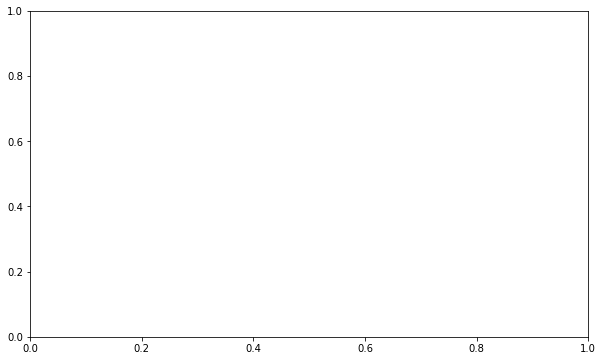

In [11]:
ind = np.arange(acc_scores.shape[1])
width = 0.05

fig, ax = plt.subplots(figsize=(10, 6))
acc_bars = ax.bar(ind-width/2, list(acc_scores.mean(axis=1)), width, yerr=list(acc_scores.std(axis=1)), label='Accuracy',
                 error_kw=dict(capsize=5, lw=0.5, capthick=0.5), color='lightskyblue', ecolor='navy')
F1_bars = ax.bar(ind+width/2, list(F1_scores.mean(axis=1)), width, yerr=list(F1_scores.std(axis=1)), label='F1-score')
plt.ylim(ymin = 0.9, ymax = 1)
ax.set_xticks(ind)
ax.set_xticklabels(acc_scores.columns)
plt.legend()

plt.tight_layout()
fig.savefig('Model_Metrics/Compared_Performances.png', dpi=300)

#### Verification of parameters with one change

In [ ]:
def plot_results(grid, name, est=rf_tuned, x=x, y=y, sigma=sigma):
    
    param_name = 'param_%s' % list(grid.keys())[0]

    trainscores = pd.DataFrame()
    testscores = pd.DataFrame()
    fittime = pd.DataFrame()
    
    for i in range(10):
        # Create a model with 10-fold cross validation
        model = GridSearchCV(est=rf_tuned, param_grid=grid, cv=10, scoring='accuracy', return_train_score=True)
        
        # Add random Gaussian noise with every repetition
        noise = np.random.normal(0, sigma, size=x.shape)
        x = x + noise
        model.fit(x, y)

        # Extract information from the cross validation model
        trainscores.loc[:,i] = model.cv_results_['mean_train_score']
        testscores.loc[:,i] = model.cv_results_['mean_test_score']
        fittime.loc[:,i] = model.cv_results_['mean_fit_time']
    
    train_scores = trainscores.mean(axis=1)
    train_std    = trainscores.std(axis=1)
    
    test_scores  = testscores.mean(axis=1)
    test_std     = testscores.std(axis=1)
    
    time_mean    = fittime.mean(axis=1)
    time_std     = fittime.std(axis=1)
    
    param_values = list(model.cv_results_[param_name])
    print(param_values)
    
    
    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(10, 6))
    plt.subplot(121)
    plt.plot(param_values, train_scores, 'b-', label = 'train')
    plt.fill_between(param_values, train_scores-train_std, train_scores+train_std, alpha=0.5, color='b')
    plt.plot(param_values, test_scores, 'g-', label = 'test')
    plt.ylim(ymin = 0.94, ymax = 1)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Accuracy')
    plt.title('accuracy vs %s' % name)
    
    plt.subplot(122)
    plt.plot(param_values, time_mean, 'r-')
    plt.fill_between(param_values, time_mean-time_std, time_mean+time_std, alpha=0.5, color='r')
    plt.ylim(ymin = 0.0, ymax = 1.5)
    plt.xlabel(name)
    plt.ylabel('Train time (sec)')
    plt.title('Training time vs %s' % name)
    
    plt.tight_layout(pad = 4)

#### feature selection

In [ ]:
# file_list = {'benign plain.pcap':0,
#              'dns2tcp tunneling.pcap':1,
#              'dnscapy tunneling.pcap':1,
#              'iodine tunneling.pcap':1,
#              'tuns_c_00000_20180330104021.pcap':1}

# for file, label in file_list.items():
#     print(label, '\t' , 'data/pcaps/'+file)



In [ ]:
importances = pd.DataFrame(rf_tuned.feature_importances_, columns=['fi'], index=features)
importances['std'] = np.std([tree.feature_importances_ for tree in rf_tuned.estimators_], axis=0, ddof=1)
importances.sort_values('fi', ascending=False, inplace=True)
display(importances)

In [ ]:
sel = SelectFromModel(rf_tuned)
sel.fit(x_train, y_train)
selected_feat= df.loc[:,features].columns[(sel.get_support())]
print(list(selected_feat))

In [ ]:
pd.Series(sel.estimator_.feature_importances_.ravel()).hist()